<small>
Copyright (c) 2017 Andrew Glassner

Permission is hereby granted, free of charge, to any person obtaining a copy of this software and associated documentation files (the "Software"), to deal in the Software without restriction, including without limitation the rights to use, copy, modify, merge, publish, distribute, sublicense, and/or sell copies of the Software, and to permit persons to whom the Software is furnished to do so, subject to the following conditions:

The above copyright notice and this permission notice shall be included in all copies or substantial portions of the Software.

THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY, FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM, OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE SOFTWARE.
</small>



# Deep Learning From Basics to Practice
## by Andrew Glassner, https://dlbasics.com, http://glassner.com
------
## Chapter 12: Data Preparation
### Notebook 2: PCA on Images

This notebook is provided as a “behind-the-scenes” look at code used to make some of the figures in this chapter. It is still in the hacked-together form used to develop the figures, and is only lightly commented.

In [1]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np

from keras.preprocessing.image import ImageDataGenerator
from keras import backend as keras_backend

from sklearn.decomposition import PCA
import seaborn as sns ; sns.set()

# Just in case the config file isn't set up as we expect
keras_backend.set_image_data_format('channels_last')

Using TensorFlow backend.


In [2]:
# Make a File_Helper for saving and loading files.

save_files = True

import os, sys, inspect
current_dir = os.path.dirname(os.path.abspath(inspect.getfile(inspect.currentframe())))
sys.path.insert(0, os.path.dirname(current_dir)) # path to parent dir
from DLBasics_Utilities import File_Helper
file_helper = File_Helper(save_files)

In [3]:
def plot_six(images, titles):
    plt.figure(figsize=(9, 4))
    plt.subplots_adjust(bottom=0, left=.01, right=.99, top=.90, hspace=.35)
    for i in range(6):
        plt.subplot(1, 6, i + 1)
        vmin, vmax = np.min(images[i]), np.max(images[i])
        plt.imshow(images[i].reshape((img_hgt, img_wid)), vmin=vmin, vmax=vmax, cmap=plt.cm.gray)
        plt.title(titles[i], size=12)
        plt.xticks(())
        plt.yticks(())

In [4]:
def plot_twelve(images, titles):
    plt.figure(figsize=(9, 5))
    plt.subplots_adjust(bottom=0, left=.01, right=.99, top=.90, hspace=.35)
    for i in range(6):
        plt.subplot(2, 6, i + 1)
        vmin, vmax = np.min(images[i]), np.max(images[i])
        plt.imshow(images[i].reshape((img_hgt, img_wid)), vmin=vmin, vmax=vmax, cmap=plt.cm.gray)
        plt.title(titles[i], size=12)
        plt.xticks(())
        plt.yticks(())
        plt.subplot(2, 6, i + 6 + 1)
        vmin, vmax = np.min(images[i+6]), np.max(images[i+6])
        plt.imshow(images[i+6].reshape((img_hgt, img_wid)), vmin=vmin, vmax=vmax, cmap=plt.cm.gray)
        plt.title(titles[i+6], size=12)
        plt.xticks(())
        plt.yticks(())

In [5]:
def get_input_dogs():
    # read in the dogs
    pixdir = file_helper.get_input_data_dir()
    basenames = ('husky-bw-1105338-64', 'husky-bw-1328899-64', 'husky-bw-2016708-64',
                 'husky-bw-2332240-64', 'husky-bw-2562252-64', 'husky-bw-2671006-64')

    input_dogs = []
    for i in range(len(basenames)):
        img = mpimg.imread(pixdir+'/'+basenames[i]+'.png')
        if i==0:
            img_hgt = img.shape[0]
            img_wid = img.shape[1]
        flat_img = np.reshape(img[:,:,0], [img_wid * img_hgt])
        input_dogs.append(flat_img)
    input_dogs = np.array(input_dogs)
    return input_dogs, img_wid, img_hgt

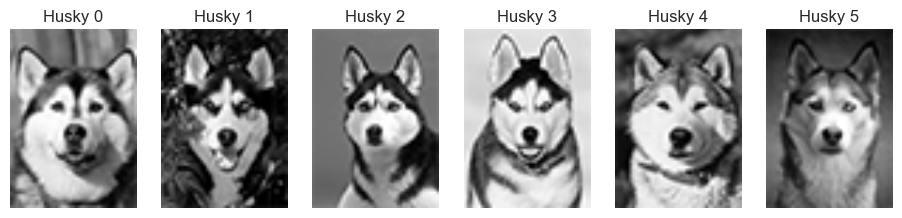

In [6]:
# show the original dogs
input_dogs, img_wid, img_hgt = get_input_dogs()

original_titles = ["Husky %d" % i for i in range(len(input_dogs))]
plot_six(input_dogs, original_titles)
file_helper.save_figure('dogs-starting')
plt.show()

In [7]:
def generate_many_dogs(input_dogs, database_size):
    # use the input_dogs to generate a whole lot of dogs
    random_seed = 42
    np.random.seed(random_seed)
    input_dogs4D = np.reshape(input_dogs, (len(input_dogs), img_hgt, img_wid, 1))
    generator = ImageDataGenerator(width_shift_range=0.1, height_shift_range=0.1, rotation_range=5, horizontal_flip=True)
    generator.fit(input_dogs4D)

    dogs = []
    while len(dogs) < database_size:
        for X_batch, y_batch in generator.flow(input_dogs4D, range(len(input_dogs4D)), batch_size=32):
            for img in X_batch:
                flat_img = np.reshape(img[:,:,0], [img_wid*img_hgt])
                if len(dogs) < database_size:
                    dogs.append(flat_img)
            break
            
    return dogs

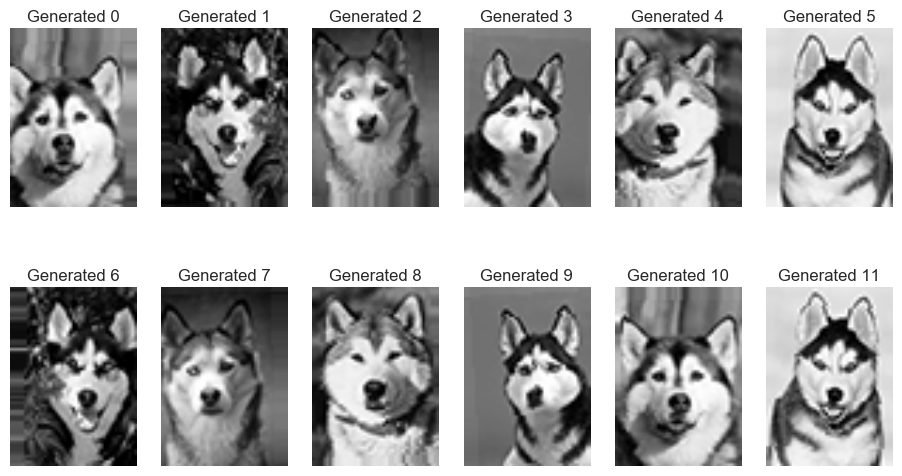

In [8]:
# How many dogs do we want to generate for training on?
training_set_size = 4000

dogs = generate_many_dogs(input_dogs, training_set_size)

original_titles = ["Generated %d" % i for i in range(len(dogs))]
plot_twelve(dogs, original_titles)
file_helper.save_figure('dogs-generated')
plt.show()

In [9]:
def standardize_dogs(dogs):
    # Standardize each feature into new variable Sdogs
    Sdogs = np.copy(dogs)
    for f in range(Sdogs.shape[1]):  # for every feature (every pixel)
        feature_center = np.mean(Sdogs[:, f])
        feature_sigma = np.sqrt(np.var(Sdogs[:, f]))
        if feature_sigma != 0:
            Sdogs[:,f] = [(v-feature_center)/feature_sigma for v in Sdogs[:, f]]
    return Sdogs

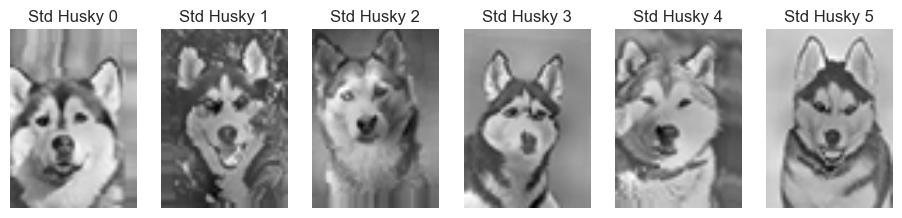

In [10]:
Sdogs = standardize_dogs(dogs)

original_titles = ["Std Husky %d" % i for i in range(len(Sdogs))]
plot_six(Sdogs, original_titles)
file_helper.save_figure('dogs-standardized')
plt.show()

In [11]:
def get_eigendogs(dogs, num_eigendogs):
    pca = PCA(n_components=num_eigendogs).fit(dogs)
    eigendogs = pca.components_.reshape((pca.components_.shape[0], img_hgt, img_wid))
    return pca, eigendogs

In [12]:
def rebuild_from_eigendogs(dogs, pca, eigendogs):
    # rebuild each dog as a combination of eigendogs
    rebuilt_dogs = []
    weights_list = []
    for i in range(len(dogs)):
        img = np.copy(dogs[i])
        img = img.reshape(1, -1)
        weights = pca.transform(img)[0]
        weights_list.append(weights)
        proj_dog = np.zeros((img_hgt, img_wid))
        for j in range(len(weights)):
            proj_dog += weights[j] * np.array(eigendogs[j])
        flat_dog = np.ravel(proj_dog)
        rebuilt_dogs.append(proj_dog)
    rebuilt_dogs = np.array(rebuilt_dogs)
    return rebuilt_dogs, weights_list

In [13]:
def show_rebuilds(rebuilt_dogs, weights_list, num_eigendogs):
    # Show the reguilt dogs along with their weights
    rebuilt_titles = ["Rebuild %d" % i for i in range(rebuilt_dogs.shape[0])]

    plt.figure(figsize=(9, 5))
    plt.subplots_adjust(bottom=0, left=.01, right=.99, top=.90, hspace=.35)
    for i in range(6):
        img_index = [0, 1, 2, 6, 7, 8][i]
        plt.subplot(2, 6, i + 1)
        img = rebuilt_dogs[i]
        vmin, vmax = np.min(img), np.max(img)
        plt.imshow(img.reshape((img_hgt, img_wid)), vmin=vmin, vmax=vmax, cmap=plt.cm.gray)
        plt.title(rebuilt_titles[i], size=12)
        plt.xticks(())
        plt.yticks(())
        plt.subplot(2, 6, i+1+6)
        plt.bar(range(len(weights_list[i])), weights_list[i], 0.75, align='center')
        plt.xticks([],[])
    title = "Reconstructions from "+str(num_eigendogs)+" eigendogs"
    plt.suptitle(title)
    file_helper.save_figure('dogs-rebuilt-'+str(num_eigendogs))
    plt.show()

In [14]:
def apply_and_rebuild(dogs, num_eigendogs, save_eigendogs):
    pca, eigendogs = get_eigendogs(dogs, num_eigendogs)

    if save_eigendogs:
        eigenface_titles = ["eigendog %d" % i for i in range(eigendogs.shape[0])]
        plot_twelve(eigendogs, eigenface_titles)
        plt.suptitle("Eigendogs")
        file_helper.save_figure('eigendogs')
        plt.show()
    
    rebuilt_dogs, weights_list = rebuild_from_eigendogs(Sdogs, pca, eigendogs)
    show_rebuilds(rebuilt_dogs, weights_list, num_eigendogs)

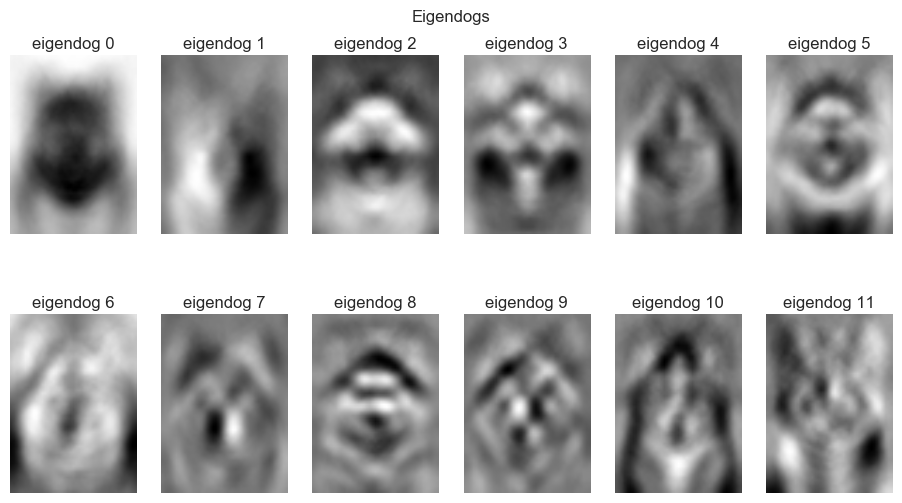

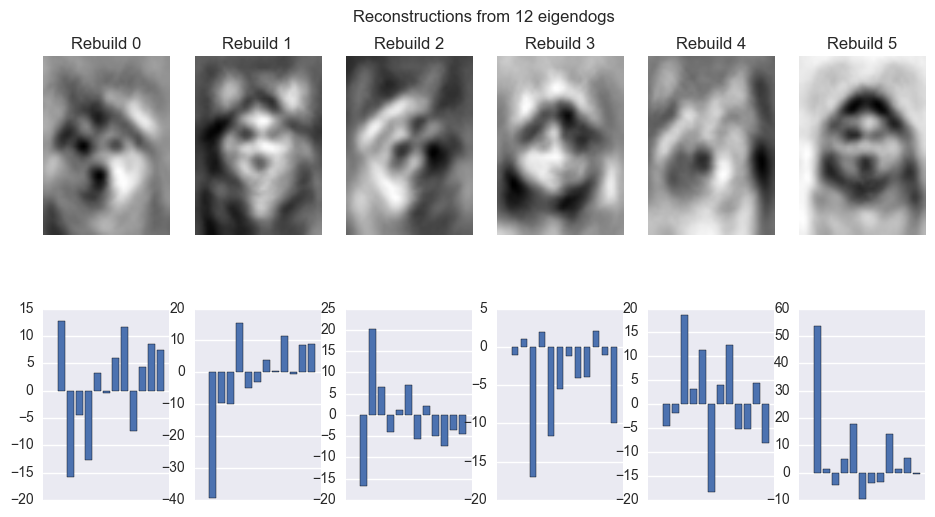

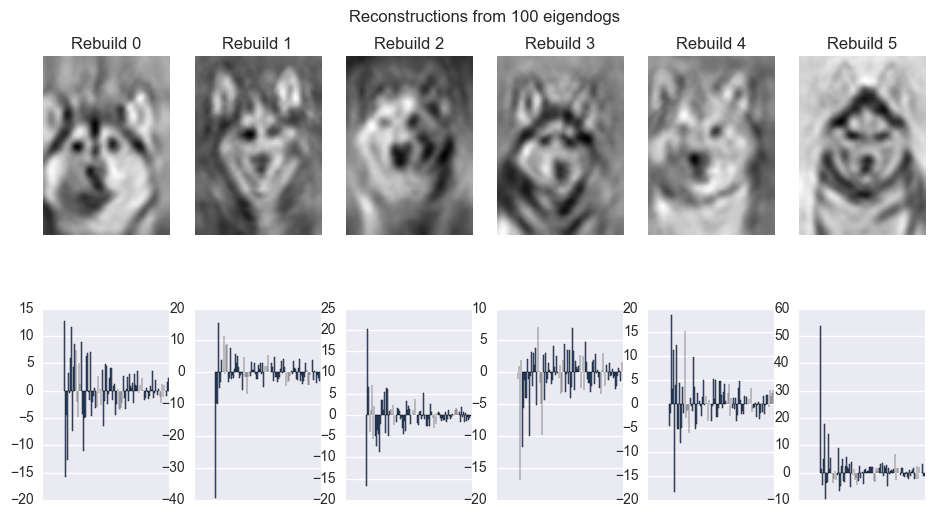

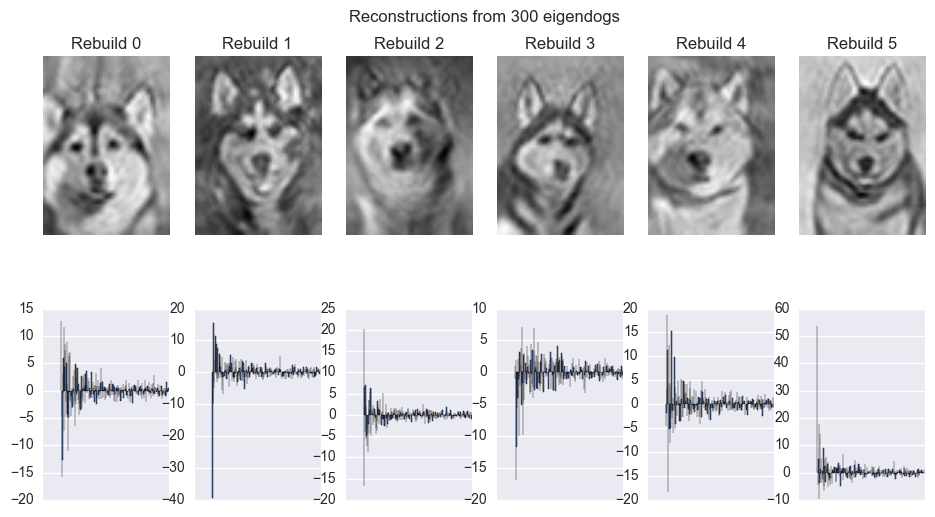

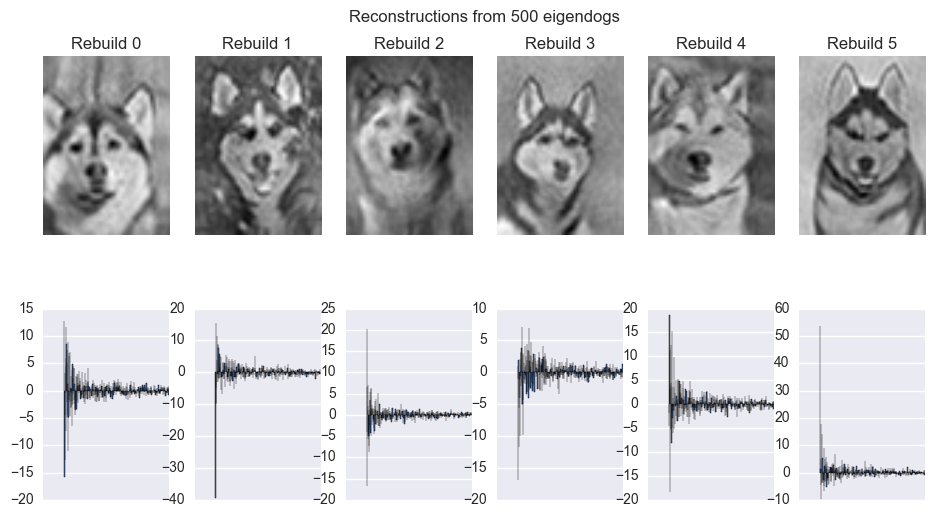

In [15]:
num_eigendogs = [12, 100, 300, 500]
for i in range(len(num_eigendogs)):
    apply_and_rebuild(Sdogs, num_eigendogs[i], i==0)